# Group 33 Project Report

Date: April 16, 2021

Group Members: Kyra Priestman, Vita Chan, Alex Piarkouski, Shinichi Ishikawa

### _Predicting Forest Fire Occurrence Based on Weather Conditions_

### Introduction

Fires are the most devastating natural threat to wooded areas of the Mediterranean[1]. In Algeria, about 0.4 million hectares of forest were burned from 2006 to 2010[5]. Additionally, several sources estimate the total annual cost of firefighting and safety devices in the Mediterranean region to be more than $1 billion USD[1]. 

As the fire spreads, it becomes increasingly difficult for firefighters to control. Therefore, it’s essential to be able to predict the likelihood of a fire occurring for given weather conditions, so that authorities can react swiftly and prepare for potential forest fires during high-hazard conditions. 

**Scientific Question and Dataset Description**

_Using K-nearest neighbours classification, can forest fires be accurately predicted using past weather condition data?_

The dataset that we will be using is the “Algerian Forest Fires Dataset” from Abid Faroudja of the Center for Development of Advanced Technologies[4]. It is accessible via the UCI Machine Learning Repository. The Algerian Forest Fires dataset investigates the Bejaia and Sidi Bel-abbes regions from June to September 2012, using 11 weather-related attributes to determine if a forest fire occurred or not (Class attribute). 

### Methods & Results

We decided to use the K-nearest neighbors classification algorithm for our model because we are predicting a categorical class (fire or not fire) based on quantitative variables. To start, we performed a preliminary step of splitting our dataset into training and testing sets. With the training set we conducted an exploratory data analysis where we standardized the data and created scatterplot visualizations to determine if there were relationships between our predictors of interest and whether or not there was a forest fire. Only the variables with strong relationships with our class variable were used in our final classifier. 

Once we had determined which variables would be used as predictors, we conducted a 5-fold cross-validation with our training set to determine an optimal k-value to build our classifier with. A line plot was used to help us visualize which k-value produced the highest estimated accuracy. 

Afterwards, we built our final classifier using the chosen k-value. The classification algorithm was used on our testing set which helped us determine the estimated accuracy of our final k-nearest neighbors classification algorithm. 

We expect our classifier to have a high level of accuracy, upwards of 85%, because our chosen predictors are highly relevant to the outcome of fire occurrence. To elaborate, Natural Resources Canada uses the weather observations of temperature, relative humidity, wind, and rain to compose their Fire Weather Index that provides an outlook for rating forest fire danger[7]. Therefore, our classifier should have a high level of accuracy because it uses strong predictors to determine fire or non-fire occurrence, which are used in professional forest fire prediction by the Canadian Government. 

**Loading Libraries**

In [23]:
#Loading packages
library(repr)
library(tidyverse)
library(tidymodels)

#Setting seed so we get reasonably random numbers
set.seed(1000)

#Helper function for visualization
options(repr.matrix.max.rows = 6)

**Reading, Cleaning, and Wrangling**

First we read the “Algerian Forest Fires Dataset” from the UCI Machine Learning Repository. After viewing the dataset, we noticed that rows 1, 123, 124 from the original dataset were metadata. Therefore, those rows were skipped along with any empty rows. Additionally, row 168 was formatted improperly (a delimiter is missing), therefore that row was skipped as well.

In the original dataset, data from the Bejaia and Sidi Bel-abbes regions were separated into two data tables. However, for this analysis we decided to combine the two into one data table.  

Lastly, we decided to rename the "Classes" column to fire_occurrence to be descriptive. 

In [20]:
#Reading, cleaning, and wrangling the data
fire_data_1 <- (read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv",
                       skip = 1, skip_empty_rows = TRUE, col_names = TRUE)[-c(123, 124, 168),]) %>%
                mutate(Classes = as_factor(Classes), 
                      Temperature = as.numeric(Temperature), 
                      RH = as.numeric(RH),
                      Ws = as.numeric(Ws),
                      Rain = as.numeric(Rain),
                      FWI = as.numeric(FWI),
                      )

#Renaming Classes to more descriptive title of "fire_occurrence"
names(fire_data_1)[names(fire_data_1) == 'Classes'] <- 'fire_occurrence'

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“2 parsing failures.
row col   expected     actual                                                                                                       file
123  -- 14 columns 1 columns  'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
168  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
”


_**Table 1:** Cleaned Algerian Forest Fires Dataset_

In [22]:
fire_data_1

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,fire_occurrence
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>
01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,09,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire
29,09,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire
30,09,2012,24,64,15,0.2,67.3,3.8,16.5,1.2,4.8,0.5,not fire


**Training and Test Sets**

In order to be able to accurately measure the accuracy of our classification algorithm, it was necessary for us to split our data into training and testing sets. We split the data such that the training set included 75% of the overall dataset and the test set included the remaining 25% of the data. Only the training set was used for the standardization process and creating the tables and visualizations in our preliminary data analysis to ensure that the testing set remains hidden while we built our classifier.

In [24]:
#Filtering first for our desired predictors and Class variable
filtered_fire <- fire_data_1 %>%
select(Temperature, RH, Ws, Rain, FWI, fire_occurrence)

#Splitting into training and test sets
fire_split <- initial_split(filtered_fire, prop = 0.75, strata = fire_occurrence)
fire_train <- training(fire_split)
fire_test <- testing(fire_split)

_**Table 2:** Algerian Forest Fire Data with 4 Chosen Predictors and 1 Class Variable - Training Set_

In [25]:
fire_train

Temperature,RH,Ws,Rain,FWI,fire_occurrence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,57,18,0.0,0.5,not fire
29,61,13,1.3,0.4,not fire
25,89,13,2.5,0.0,not fire
⋮,⋮,⋮,⋮,⋮,⋮
30,65,14,0.0,6.5,fire
28,87,15,4.4,0.0,not fire
24,54,18,0.1,0.7,not fire


_**Table 3:** Algerian Forest Fire Data with 4 Chosen Predictors and 1 Class Variable - Testing Set_

In [26]:
fire_test

Temperature,RH,Ws,Rain,FWI,fire_occurrence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
26,82,22,13.1,0.1,not fire
28,79,12,0.0,0.9,not fire
27,84,21,1.2,0.2,not fire
⋮,⋮,⋮,⋮,⋮,⋮
33,64,13,0.0,13.7,fire
27,87,29,0.5,0.2,not fire
24,64,15,0.2,0.5,not fire


**Exploratory Analysis: Summarizing Data in a Table - Number of Observations for "Fire" and "Not Fire"**

We counted the number of observations for each class to determine whether or not there may be a class imbalance. Based on the summary, we could see that there were 23 more observations for the "fire" class than the "not fire" class. This slight difference indicated that there was no need to balance our data. Also, considering that we were trying to determine which attributes were most likely to result in a fire occurring, our results should not be skewed by this slight difference in number of observations. With more "fire" observations, we could even observe the common attributes within this class, as they all resulted in a fire occurring (e.g. increased rain was common throughout most of the "fire" observations). 

In [27]:
#Summarizing the training data in a table
observations_classes <- fire_train %>%  
                        select(fire_occurrence) %>%  
                        group_by(fire_occurrence) %>%  
                        summarize(n = n(),
                        percentage = n() / nrow(fire_train) * 100)

`summarise()` ungrouping output (override with `.groups` argument)



_**Table 4:** Number of Observations for Class Variable Labels "Fire" and "Not Fire"_

In [28]:
observations_classes

fire_occurrence,n,percentage
<fct>,<int>,<dbl>
not fire,80,43.71585
fire,103,56.28415


**Exploratory Analysis: Preliminary Visualizations**

Prior to creating our preliminary visualizations, we standardized as some variables had larger scales than others. The visualizations were used to observe the types (including direction and strength) of relationships between our chosen predictors and fire occurrence. Based on these visualizations, we have identified the following variables as being related to the fire_occurrence column which indicates whether or not there is a fire: 
* Temperature (max temperature at noon in degrees Celsius)
* RH (relative humidity in %)
* Ws (wind speed in km/h)
* Rain (total precipitation per day in mm)
* FWI (Fire Weather Index rating of fire intensity from 0 to 31.1)

The preliminary visualizations provide evidence that these variables are good candidates for potentially being informative predictors of whether or not there may be a forest fire occurrence. Therefore, all of them will be included as predictors in our classifier.

In [41]:
#Standardizing training data set
fire_recipe <- recipe(fire_occurrence ~ ., data = fire_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors()) %>%
  prep()

standard_fire <- bake(fire_recipe, fire_train)

_**Table 5:** Standardized Algerian Forest Fires Training Data Set_

In [39]:
standard_fire

Temperature,RH,Ws,Rain,FWI,fire_occurrence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.8346169,-0.35445163,0.9806118,-0.4344089,-0.8621770,not fire
-0.8346169,-0.08969796,-0.9163434,0.3449718,-0.8755731,not fire
-1.9197671,1.76357772,-0.9163434,1.0644001,-0.9291572,not fire
⋮,⋮,⋮,⋮,⋮,⋮
-0.5633294,0.1750557,-0.5369523,-0.4344089,-0.05841546,fire
-1.1059045,1.6312009,-0.1575613,2.2034949,-0.92915716,not fire
-2.1910547,-0.5530169,0.9806118,-0.3744565,-0.83538498,not fire


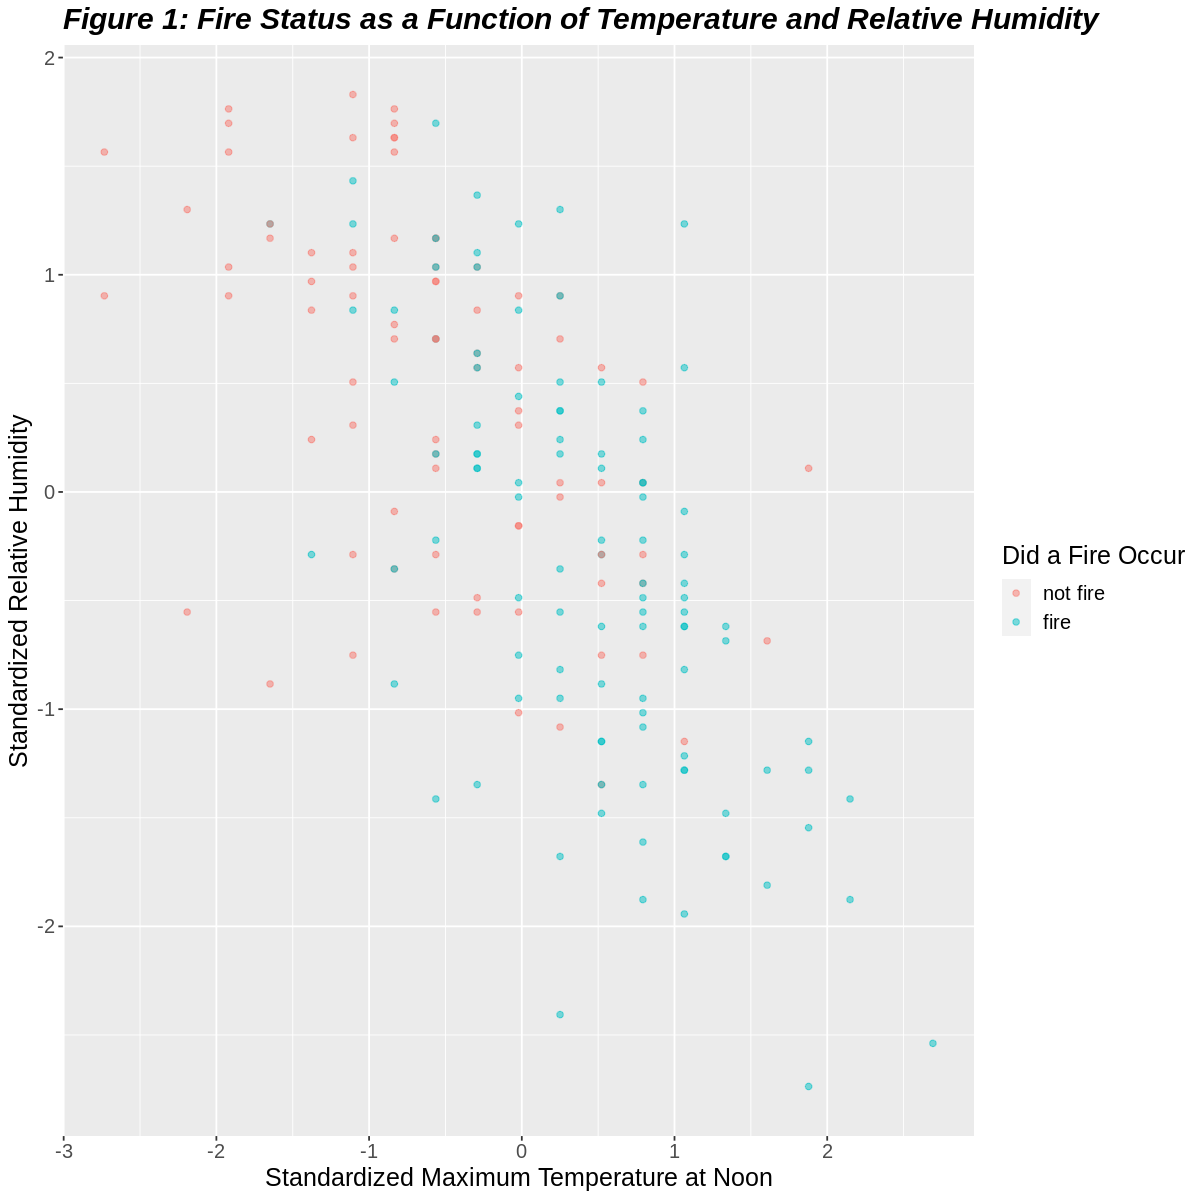

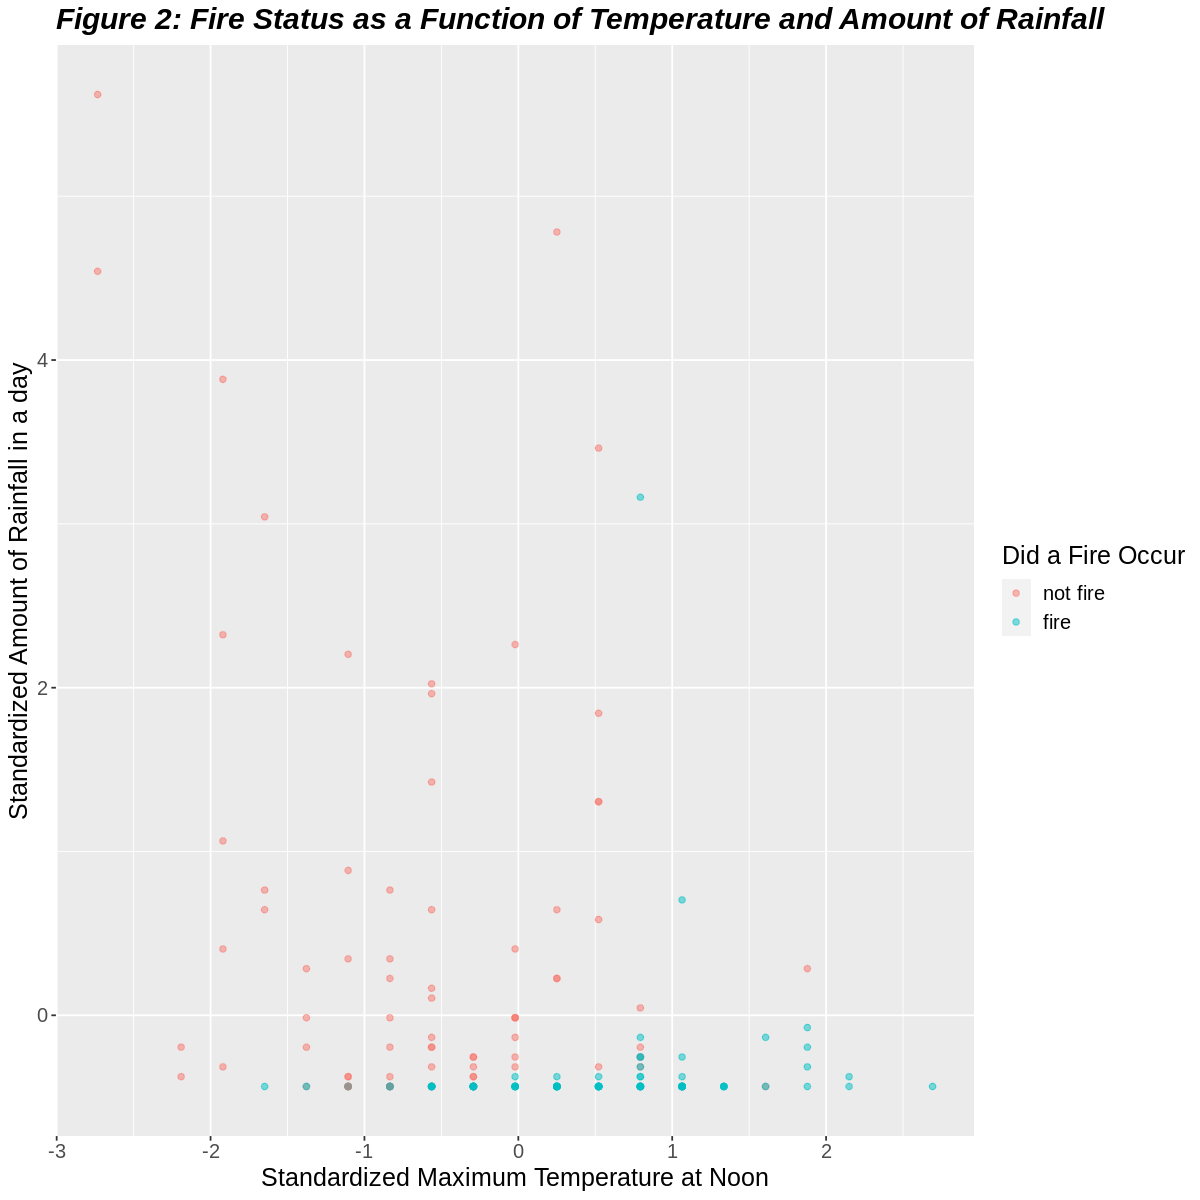

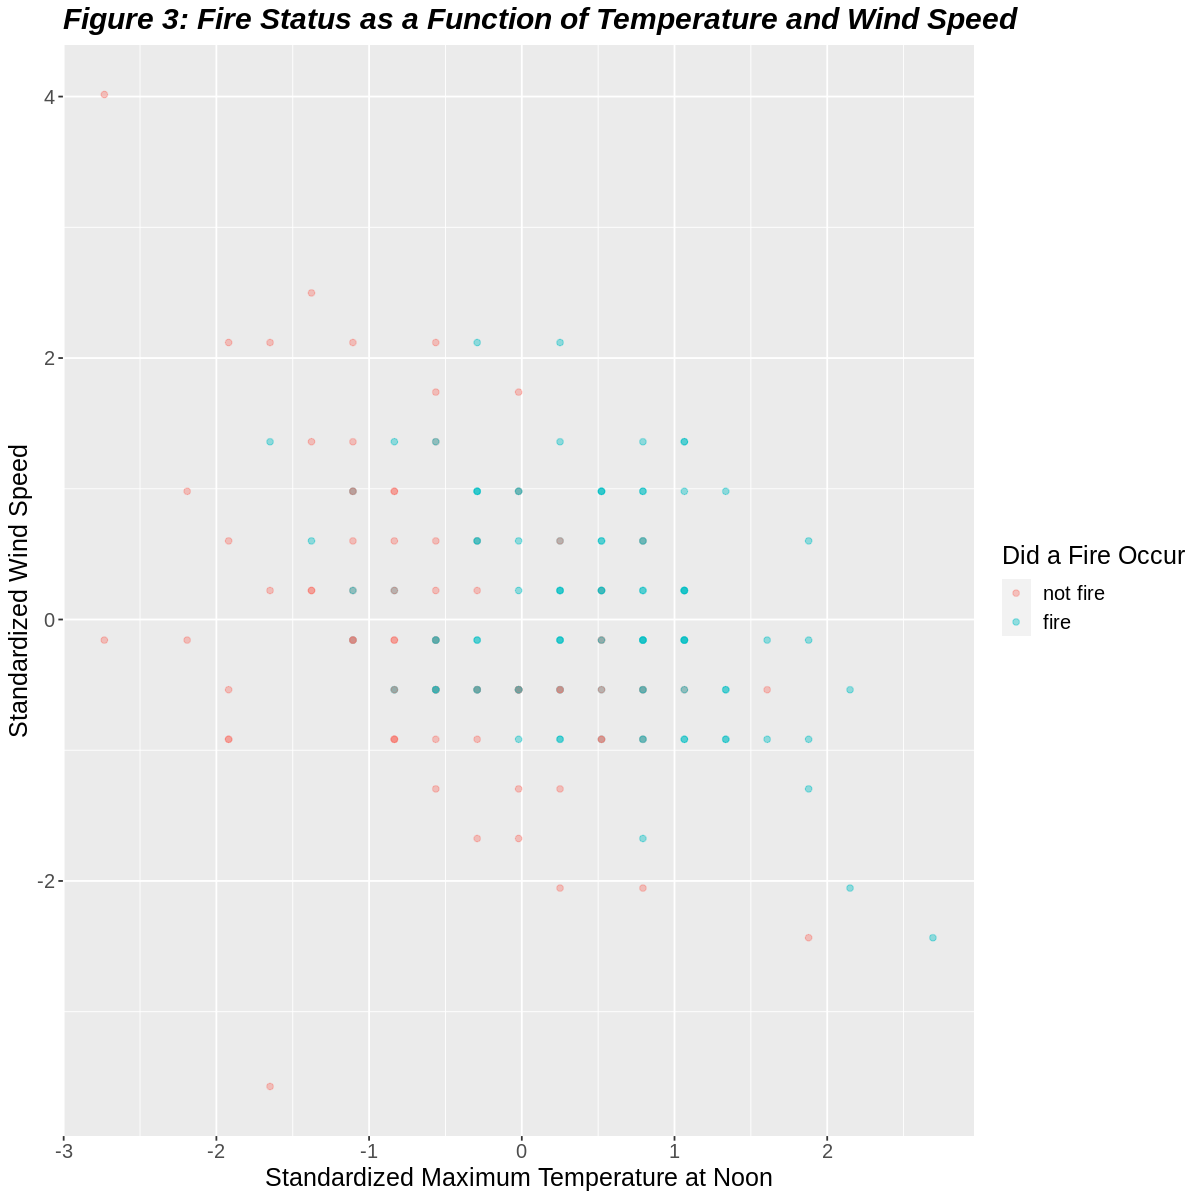

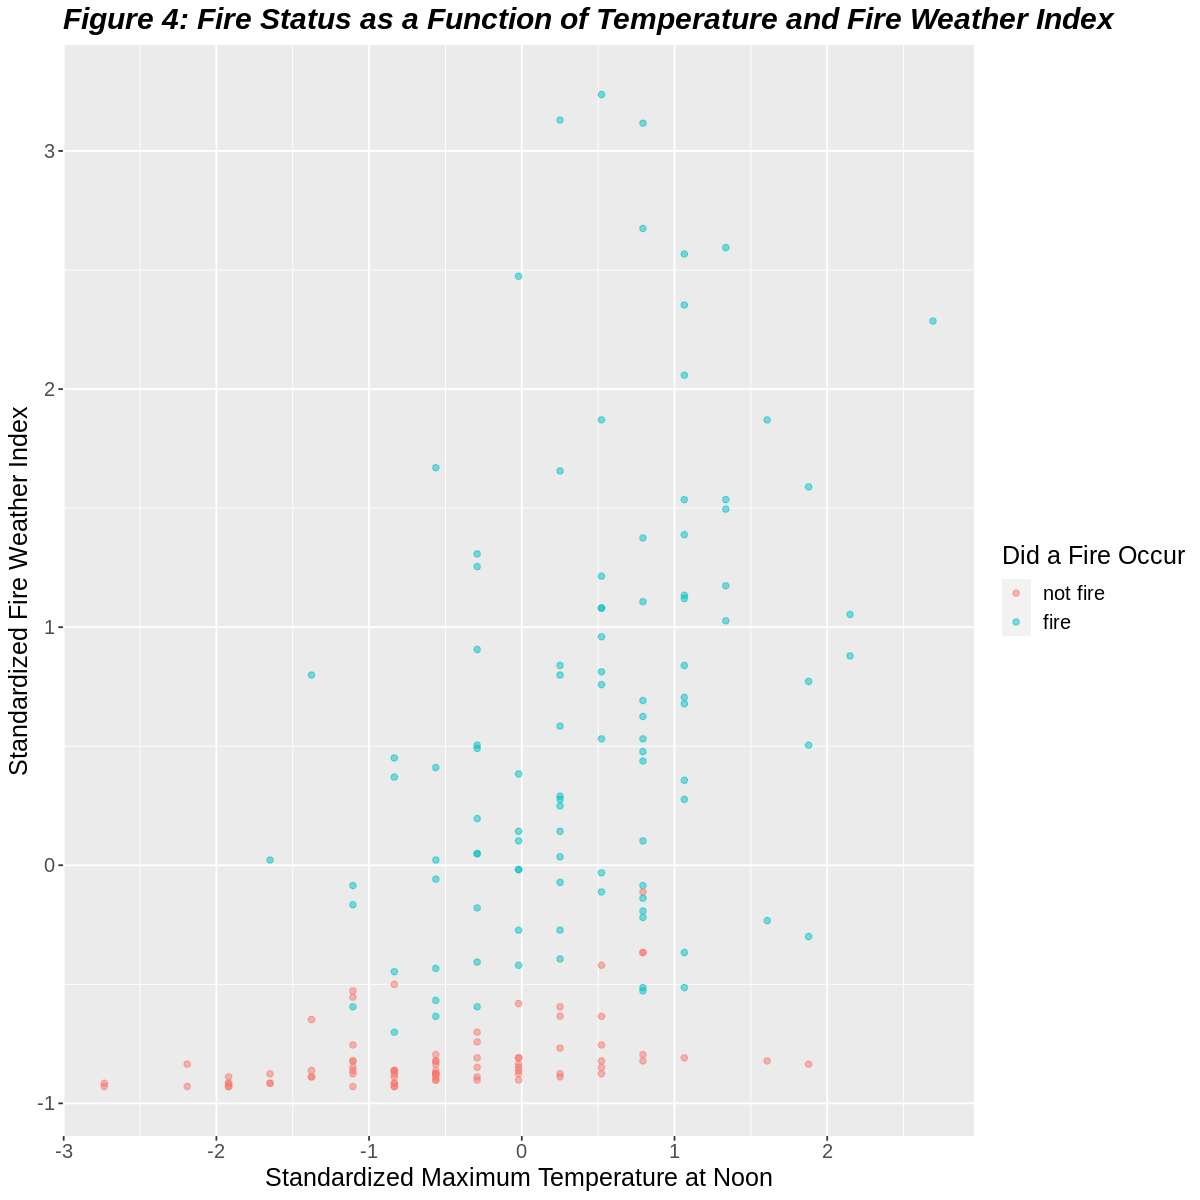

In [40]:
#Setting appropriate plot size for readability
options(repr.plot.width = 10, repr.plot.height = 10)

#Temperature and relative humidity
temperature_humidity_plot <- standard_fire %>%
                            ggplot(aes(x = Temperature, y = RH, colour = fire_occurrence)) +
                            geom_point(alpha = 0.5) + 
                            labs(x = "Standardized Maximum Temperature at Noon",
                                 y = "Standardized Relative Humidity",
                                colour = "Did a Fire Occur") +
                            ggtitle("Figure 1: Fire Status as a Function of Temperature and Relative Humidity") +
                                theme(text = element_text(size = 15), plot.title = element_text(face = "bold.italic"))
temperature_humidity_plot

#Temperature and rain
temperature_rain_plot <- standard_fire %>%
                            ggplot(aes(x = Temperature, y = Rain, colour = fire_occurrence))+
                            geom_point(alpha = 0.5) +
                            labs(x = "Standardized Maximum Temperature at Noon",
                                 y = "Standardized Amount of Rainfall in a day",
                                colour = "Did a Fire Occur") +
                            ggtitle("Figure 2: Fire Status as a Function of Temperature and Amount of Rainfall") +
                            theme(text = element_text(size = 15), plot.title = element_text(face = "bold.italic"))
temperature_rain_plot

#Temperature and wind speed
temperature_wind_plot <- standard_fire %>%
                        ggplot(aes(x = Temperature, y = Ws, colour = fire_occurrence))+
                        geom_point(alpha = 0.4) +
                        labs(x = "Standardized Maximum Temperature at Noon",
                             y = "Standardized Wind Speed",
                            colour = "Did a Fire Occur") +
                        ggtitle("Figure 3: Fire Status as a Function of Temperature and Wind Speed") +
                        theme(text = element_text(size = 15), plot.title = element_text(face = "bold.italic"))
temperature_wind_plot

#Temperature and fire weather index
temperature_FWI_plot <- standard_fire %>%
                        ggplot(aes(x = Temperature, y = FWI, colour = fire_occurrence))+
                        geom_point(alpha = 0.5) +
                        labs(x = "Standardized Maximum Temperature at Noon",
                             y = "Standardized Fire Weather Index",
                            colour = "Did a Fire Occur") +
                        ggtitle("Figure 4: Fire Status as a Function of Temperature and Fire Weather Index") +
                         theme(text = element_text(size = 15), plot.title = element_text(face = "bold.italic"))
temperature_FWI_plot

**What Do These Visualizations Tell Us?**

We used the results of these preliminary visualizations to formulate expected outcomes. We expect to find: 
* A positive correlation between fire occurrence and:
    * Temperature
    * Fire Weather Index
* A negative correlation between fire occurrence and: 
    * Relative humidity
    * Rain precipitation
* A very weak negative correlation between fire occurrence and wind speed 

The relationship (or lack of) between fire occurrence and wind speed is interesting because high wind speeds are supposed to be associated with greater forest fire spread as wind helps to bring a continuous supply of oxygen to the fire[6]. Therefore, the results of Figure 3 go against our original thought of wind speed and fire occurrence having a positive relationship, but we will stick with the prediction of a weak negative correlation for the purpose of our analysis and discussion.

**Pre-Processing the Data**

In order to determine an optimal k-value for our classifier, we decided to perform a 5-fold cross-validation. Therefore, we split the training data into 5 folds. Additionally, when creating the k-nearest neighbors model, we used tune() as the parameter for the neighbors function. The recipe used to standardize our data for our preliminary visualizations (fire_recipe) will also be used in our cross-validation. 

In [6]:
#Creating 5 folds
fire_vfold <- vfold_cv(fire_train, v = 5, strata = fire_occurrence)

#Creating the k-nearest neighbors model with tune() function in order to find the optimal k value later on.
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
              set_engine("kknn") %>%
              set_mode("classification")

**Finding the Optimal K Value**

Using the recipe and model we had created earlier, we performed our cross-validation on 10 random k-values. With the accuracy results produced, we pulled the k-value with the highest accuracy and also we created a line plot to visualize the accuracy estimate for each k-value that was used in the cross-validation. Based on the two methods we used, we found the k-value that produced the highest accuracy to be 12.

[1] 12

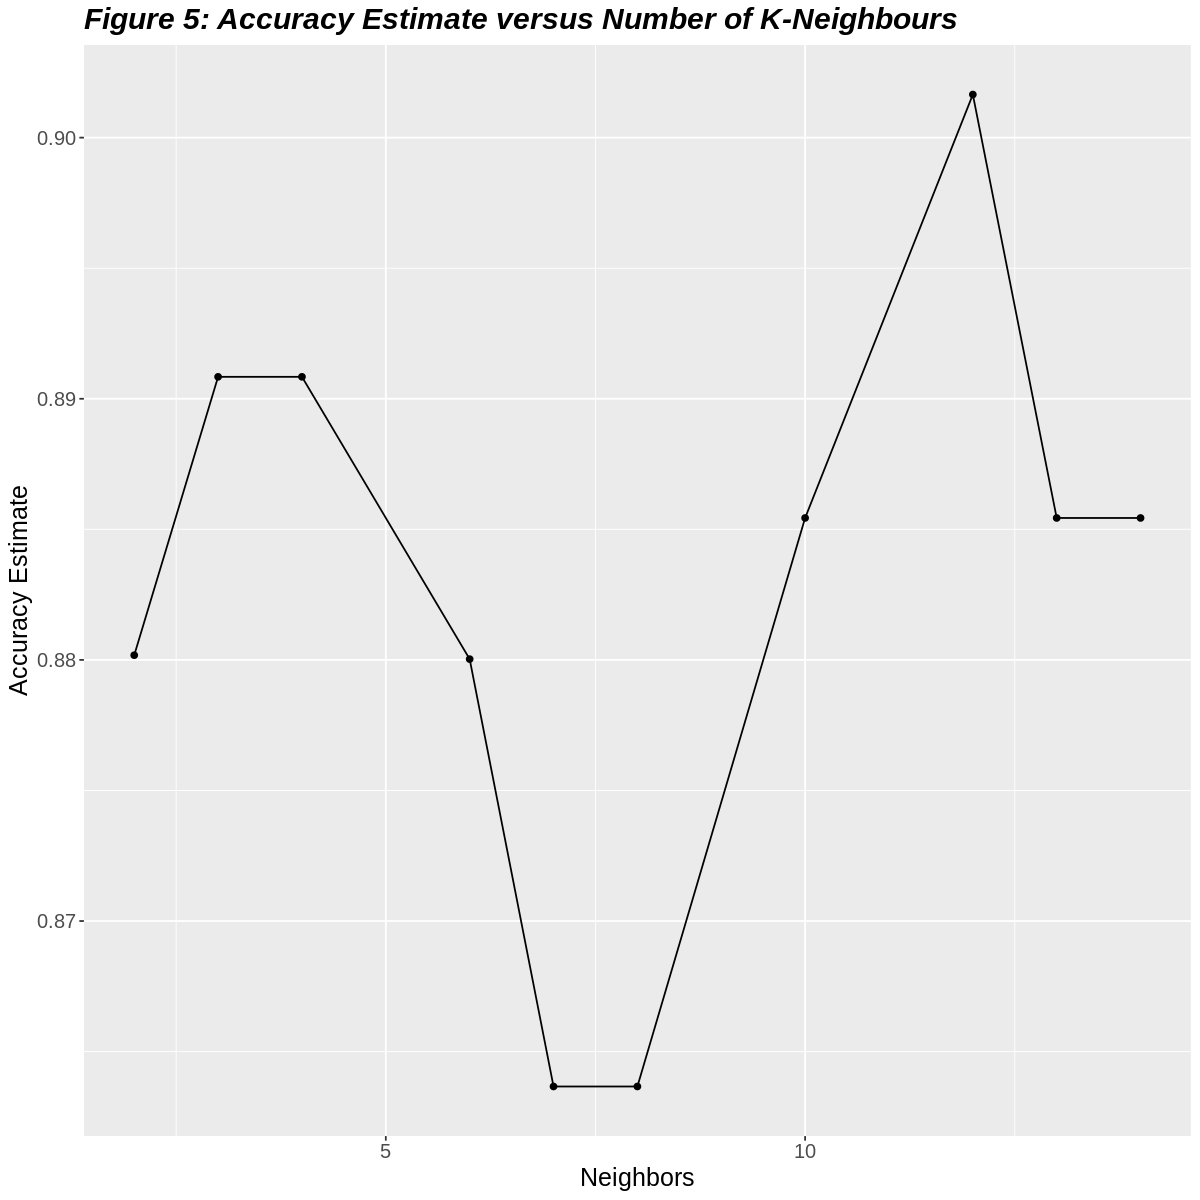

In [66]:
#Fitting the recipe and model to the dataset. Using filter() to select rows that show accuracies for 10 different k values.
accuracy_results <- workflow() %>%
  add_recipe(fire_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = fire_vfold, grid = 10) %>%
  collect_metrics() %>%
  filter(.metric == "accuracy")

#Creating k_max variable that shows the k-value with the max accuracy.
k_max <- accuracy_results %>%
    filter(mean == max(mean)) %>%
    pull(neighbors)
k_max

#Creating a graph to visualize the accuracy of different k-values.
accuracy_vs_k <- ggplot(accuracy_results, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
ggtitle("Figure 5: Accuracy Estimate versus Number of K-Neighbours") +
theme(text = element_text(size = 15), plot.title = element_text(face = "bold.italic"))
accuracy_vs_k

From Figure 5, we chose k = 12 to be the number of neighbours to use in our model as it shows the greatest accuracy estimate from our cross-validation. 

**Testing the Accuracy of the Model**

Using a k-value of 12, we ran our algorithm on the testing set which produced a predictive accuracy of 93.33%. Along with this, our model more often confuses a fire for safe conditions, while there was only one time that a fire was inaccurately predicted as not fire. 

In [48]:
# Recreating the model with the optimal k value that has been found previously.
knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) %>%
                    set_engine("kknn") %>%
                    set_mode("classification")

#Retraining the data with the new model and fire_train dataset.
fire_fit <- workflow() %>%
              add_recipe(fire_recipe) %>%
              add_model(knn_spec_tuned) %>%
              fit(data = fire_train)

#Predicting the fire_occurrence based on the predictors using predict(). The predicted values are binded and named as .pred_class.
fire_test_predictions <- predict(fire_fit, fire_test) %>%
                          bind_cols(fire_test)

#Evaluating classifier accuracy by collecting prediction metrics and creating a confusion matrix
fire_test_accuracy <- fire_test_predictions %>%
                        metrics(truth = fire_occurrence, estimate = .pred_class)

fire_test_confusion_matrix <- fire_test_predictions %>%
    conf_mat(truth = fire_occurrence, estimate = .pred_class)

_**Table 6:** Fire Occurrence Predictions Performed by Our Classifier_

In [42]:
fire_test_predictions

.pred_class,Temperature,RH,Ws,Rain,FWI,fire_occurrence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not fire,26,82,22,13.1,0.1,not fire
not fire,28,79,12,0.0,0.9,not fire
not fire,27,84,21,1.2,0.2,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮
fire,33,64,13,0.0,13.7,fire
not fire,27,87,29,0.5,0.2,not fire
not fire,24,64,15,0.2,0.5,not fire


_**Table 7:** Accuracy of Our Classifier's Predictions with the Testing Set_

In [43]:
fire_test_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9333333
kap,binary,0.8630137


_**Table 8:** Confusion Matrix for Our Classifier - Predicted Labels and True Labels_

In [45]:
fire_test_confusion_matrix

          Truth
Prediction not fire fire
  not fire       23    1
  fire            3   33

**Showing 20 Observations Each for Fire and Not Fire from the Predictions**

We printed 20 observations for fire and not fire accurate predictions to provide a rough overview of each Class as well as characteristics of the predictors (mainly for the purpose comparing our results with our initial expectations in the Discussion section). 

In [60]:
#Filtering for accurate fire predictions by choosing observations where the predicted "fire" label equals the true "fire" label 
accurate_fire_test_predictions <- filter(fire_test_predictions, .pred_class == "fire", fire_occurrence == "fire") 

#Filtering for accurate not fire predictions by choosing observations where the predicted "not fire" label equals the true "not fire" label
 accurate_not_fire_test_predictions <- filter(fire_test_predictions, .pred_class == "not fire", fire_occurrence == "not fire")

_**Table 9:** 20 Observations of Accurate Fire Predictions and Their Associated Predictor Variables_

In [57]:
print(accurate_fire_test_predictions, n = 20)

# A tibble: 33 x 7
   .pred_class Temperature    RH    Ws  Rain   FWI fire_occurrence
   <fct>             <dbl> <dbl> <dbl> <dbl> <dbl> <fct>          
 1 fire                 32    66    17   0     7.5 fire           
 2 fire                 32    55    14   0    13.9 fire           
 3 fire                 31    68    14   0     6   fire           
 4 fire                 36    48    13   0    15.3 fire           
 5 fire                 32    73    15   0    11.9 fire           
 6 fire                 35    64    17   0    15.7 fire           
 7 fire                 34    69    13   0     3.9 fire           
 8 fire                 35    59    17   0     9.9 fire           
 9 fire                 33    66    14   0    10.6 fire           
10 fire                 36    55    13   0.3   6.3 fire           
11 fire                 36    54    18   0    16.1 fire           
12 fire                 35    68    19   0    16.8 fire           
13 fire                 36    55    18   0 

_**Table 10:** 20 Observations of Accurate Not Fire Predictions and Their Associated Predictor Variables_

In [59]:
print(accurate_not_fire_test_predictions, n = 20)

# A tibble: 23 x 7
   .pred_class Temperature    RH    Ws  Rain   FWI fire_occurrence
   <fct>             <dbl> <dbl> <dbl> <dbl> <dbl> <fct>          
 1 not fire             26    82    22  13.1   0.1 not fire       
 2 not fire             28    79    12   0     0.9 not fire       
 3 not fire             27    84    21   1.2   0.2 not fire       
 4 not fire             28    80    17   3.1   0.1 not fire       
 5 not fire             30    89    16   0.6   0   not fire       
 6 not fire             31    67    17   0.1   2.3 not fire       
 7 not fire             32    47    13   0.3   3.9 not fire       
 8 not fire             29    68    19   1     0.4 not fire       
 9 not fire             33    69    13   0.7   0.5 not fire       
10 not fire             34    61    13   0.6   0.8 not fire       
11 not fire             35    55    12   0.4   0.8 not fire       
12 not fire             28    80    21  16.8   0.3 not fire       
13 not fire             25    78    15   3.

### Discussion

**Summary of Our Findings**

From our analysis, we found the k-value of 12 to be the optimal value for our classifier in producing the highest accuracy predictions. We found our classifier to have an accuracy of 93.33% on our testing set, which we would consider to be a fairly good level of accuracy considering the application of our data analysis. The classifier predicted 23 occurrences of not fire and 33 occurrences of fire accurately. Its inaccurate predictions were 3 occurrences of fire that are truly not fire and 1 occurrence of not fire that is truly fire. Considering the results of the confusion matrix, we feel that 93.33% is an acceptable level of accuracy, especially since our classifier more often confuses safe conditions for a fire, rather than confusing a fire for safe conditions (using k = 12). It is obviously better to be safe than sorry and be prepared for a fire that does not happen.

In real life prediction, evidently a level of 100% accuracy would be desirable, though achieving such a level is ultimately unattainable due to the natural conditions and human error[2] that cause fires. It is nearly impossible to figure out the perfect combination of weather conditions together with the chance of human error to accurately predict fires 100% of the time.

**Comparing Our Findings to What We Initially Expected**

An accuracy of 93.33% is within the range that we initially predicted (> 85%), which is likely due to the strong predictors we are using for classification. The fact that our predictors are common attributes of national fire prediction systems, as mentioned in our methods section, is probably the reason for the resulting high accuracy of the classifier.

From the tables that show 20 observations each of accurate fire and not fire predictions, we can compare the common attributes of these predictions to the results of our preliminary visualizations. There were five outcomes that we expected as a result of our preliminary plots, which we will compare to commonalities in Tables 9 and 10 in the following points. 

1. We expected to find a positive correlation between fire occurrence and temperature. Table 9 shows that higher temperatures of 31℃+ resulted in fires, which confirms our expectations, though it is important to note that non-fire occurrences in Table 10 also had comparably high temperatures of upwards of 25℃. This could mean that temperature alone does not have as strong of an influence on fire occurrence, and that it is probably high temperatures added together with other fire-favourable weather conditions that result in fire occurrence. 

2. We expected to find a positive correlation between fire occurrence and Fire Weather Index. Our analysis corresponds with this expectation as the majority of Table 9 observations have high FWI values, especially in comparison to Table 10’s FWI values that are all ≤ 3.9. 

3. We expected to find a negative correlation between fire occurrence and relative humidity. Looking at the two tables, RH does seem to be lower for fire occurrences, though approximately half of Table 10’s RH values are still in the lower range (similar to Table 9’s RH values). This means that the negative relationship between relative humidity and fire occurrence is weak. It is probable that low relative humidity (dry climate) paired with other fire-favourable weather conditions such as high temperatures, results in fire occurrence. 

4. We expected to find a negative correlation between fire occurrence and rain precipitation. Table 9 supports this hypothesis with nearly every observation having 0 mm of precipitation, while Table 10's precipitation values are almost always non-zero despite being generally low (≤ 4.7 mm except for two outliers). We can conclude that the presence of precipitation (any rainfall > 0 mm) has a greater influence on fire occurrence than the actual amount of rainfall. This differs from our initial prediction, but does not render it completely incorrect. This could mean that any rainfall whatsoever is beneficial in reducing forest fire occurrence because it dampens the trees and ground, preventing a potential fire-trigger from starting to ignite the forest. 

5. We expected to find a very weak negative correlation between fire occurrence and wind speed. Our findings uphold this expectation because there is no identifiable relationship between wind speed and fires/non-fires as the two tables show similar wind speed ranges. This could mean that wind speed merely worsens the conditions of an existing fire, while wind speed alone does not necessarily cause/prevent the occurrence of a fire. 

**Possible Impacts of Our Findings**

The impact of our findings could be significant in real life forest fire prevention and reducing the impact of fires by predicting them before they start. This would allow areas to adequately prepare in time for a fire such as evacuating citizens, alerting the appropriate rescue services, and setting up emergency shelter locations. Additionally, some fires could be prevented all together, decreasing overall fire occurrences as authorities can educate the population to avoid all fire triggers during times when the weather conditions are predicted to be ideal in leading to a forest fire. Regions that lack the data and/or technology to predict fires would especially benefit from our findings if they were made public and accessible to these regions and if these regions are of similar forest type to the Algerian one. 

**Future Questions**

Future questions that further develop on the results of our data analysis could be:
1. With increasing global temperatures, what is the predicted percentage increase in forest fires in the next decade? 
2. Will the labelling of forest fires as “natural disasters” become a thing of the past, leading them to be known as simply everyday, common occurrences as climate conditions become increasingly warmer and drier? 
3. Will current forest fire fighting methods such as using water and chemical retardants[3] become ineffective as the intensity and scale of fires worsens due to climate change? 
4. Are these predictors in fire occurrence applicable to all types of forests (e.g. rainforests, swamp forests) of different regions/countries?

### References

[1] Alexandrian, D., Esnault, F., & Calabri, G. (1998, October 30). Public policies affecting forest fires. _Forest Fires in the Mediterranean Area_. http://www.fao.org/3/x1880e/x1880e07.htm

[2] BC Wildfire Service. (2020, June 12). _Wildfire causes_. British Columbia. https://www2.gov.bc.ca/gov/content/safety/wildfire-status/about-bcws/wildfire-response/fire-characteristics/causes

[3] Evans, G. (2019, November 17). _How do you fight extreme wildfires?_ BBC News. https://www.bbc.com/news/world-50410481

[4] Faroudja, A. (2019, July 11). _Algerian forest fires dataset data set_. UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++

[5] Meddour-Sahar, O. (2015). Wildfires in Algeria: Problems and challenges. _IForest - Biogeosciences and Forestry_, 8(6), 818–826. https://doi.org/10.3832/ifor1279-007

[6] Natural Resources. (2012, February 7). _Basic forest fire suppression course - online lessons_. Nova Scotia Canada. https://novascotia.ca/natr/forestprotection/wildfire/bffsc/Lessons/lesson3/wind.asp

[7] Natural Resources Canada. (n.d.). _Canadian Wildland Fire Information System: Monthly and seasonal forecasts_. Government of Canada. https://cwfis.cfs.nrcan.gc.ca/background/summary/ffws